In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import All Important Libraries
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

###**Feature Extraction Function**

In [3]:
# function for extracting mfcc, pitch, and rms features from sound file
def extract_feature(file_name, mfcc, pitch, rms):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        result = []
        if mfcc:
            mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
            if mfccs.size > 0:
                mfccs = np.mean(mfccs.T, axis=0)
                mfccs = np.pad(mfccs, (0, 40 - len(mfccs)), mode='constant')
                result.append(mfccs)
        if pitch:
            f0, voiced_flag, voiced_probs = librosa.pyin(y=X, sr=sample_rate, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
            if np.any(voiced_flag):
                pitch_mean = np.mean(f0[voiced_flag])
                pitch_std = np.std(f0[voiced_flag])
                if np.isnan(pitch_mean) or np.isnan(pitch_std):
                    return None
                pitch = np.array([pitch_mean, pitch_std])
                pitch = np.pad(pitch, (0, 2 - len(pitch)), mode='constant')
                result.append(pitch)
       
        if rms:
            rms = librosa.feature.rms(y=X)
            if rms.size > 0:
                rms = np.mean(rms.T, axis=0)
                rms = np.pad(rms, (0, 1 - len(rms)), mode='constant')
                result.append(rms)
        
    return np.concatenate(result)

###**Loading Dataset for Training and Feature Extraction**

In [4]:
# Define the motions dictionary
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Emotions we want to observe
observed_emotions = ['sad', 'angry', 'fearful', 'surprised']

# Load the data and extract features for each sound file
def load_data():
    x, y = [], []
#      for folder in glob.glob('C:\\Users\\user\\Documents\\6th_sem_project\\speech-emotion-recognition-ravdess-data\\Actor_' + '*'):
#      for folder in glob.glob('C:\\Users\\user\\Documents\\6th_sem_project\\Reduced dataset\\Actor_' + '*'):
#      for folder in glob.glob('/content/drive/MyDrive/speech/Actor_' + '*'):
    for folder in glob.glob('/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_' + '*'):
        print(folder)
        for file in glob.glob(folder + '/*.wav'):
            file_name = os.path.basename(file)
            emotion = emotions[file_name.split('-')[2]]
            if emotion not in observed_emotions:
                continue
            # FEATURE EXTRACTION 
            feature = extract_feature(file, mfcc=True, pitch=True, rms=True)
            if feature is not None:
                x.append(feature)
                y.append(emotion)
    
    max_len = max(len(l) for l in x)
    x = [np.pad(l, pad_width=(0, max_len - len(l)), mode='constant') for l in x]
    
    # convert x to a 2D array of numeric values
    x = np.vstack(x)
    
    return np.array(x, dtype=object), np.array(y, dtype=object)


# Load the data and get the features and emotions respectively
x, y = load_data()

# Print shape of loaded data and number of features extracted
print(f'Data shape: {x.shape}')
print(f'Features extracted: {x[0].shape[0]}')


/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_18
/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_19
/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_16
/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_23
/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_21
/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_20
/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_17
/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_22
/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/speech-emotion-recognition-ravdess-data/Actor_24
/content/drive/MyDrive/Dataset_Speech

###**Graph for loaded dataset w.r.t. emotions**

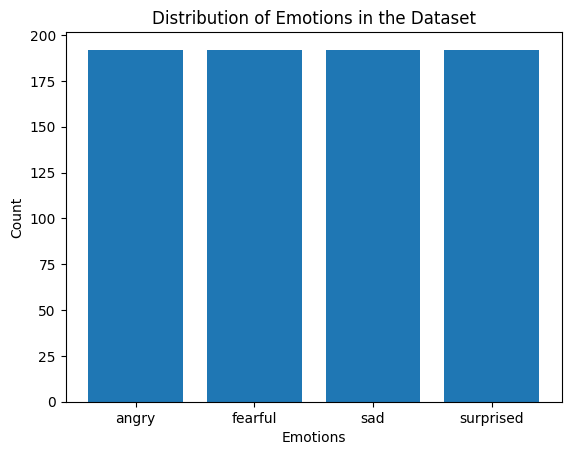

In [5]:
# Visualize distribution of emotions in the dataset
unique_emotions, emotion_counts = np.unique(y, return_counts=True)
plt.bar(unique_emotions, emotion_counts)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions in the Dataset')
plt.show()

###**Graph for MFCC coefficients for a sample audio file**

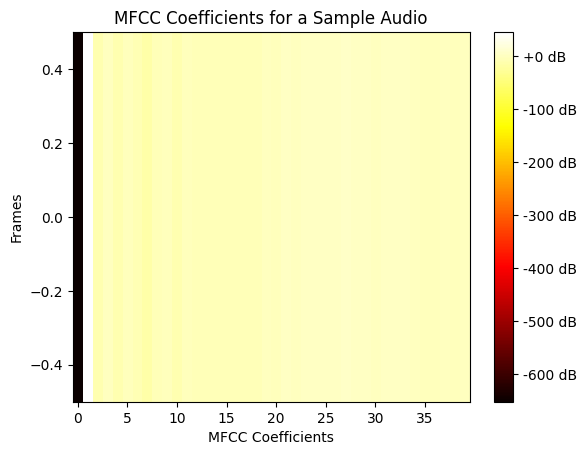

In [6]:
# Select MFCC coefficients for a sample audio file and convert to float
sample_mfcc = x[0][:40].astype(float)  # Select the first 40 MFCC coefficients and convert to float

# Reshape the MFCC coefficients to have a second dimension
sample_mfcc = sample_mfcc.reshape(1, -1)

# Plot MFCC coefficients
plt.imshow(sample_mfcc, aspect='auto', origin='lower', cmap='hot')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('MFCC Coefficients')
plt.ylabel('Frames')
plt.title('MFCC Coefficients for a Sample Audio')
plt.show()


###**Graph for PITCH feature for a sample audio file**

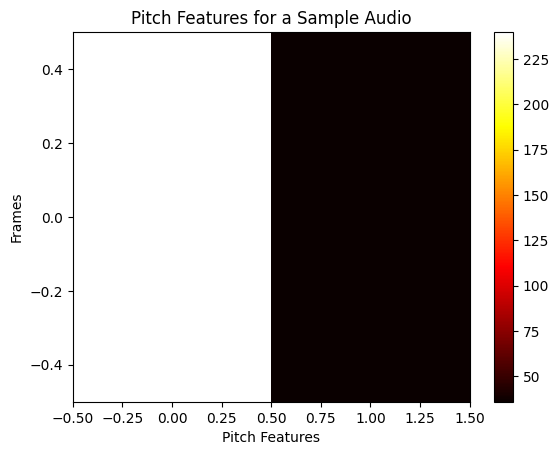

In [7]:
# Select Pitch features for a sample audio file and convert to float
sample_pitch = x[0][40:42].astype(float)  # Select the Pitch features and convert to float

# Reshape the Pitch features to have a second dimension
sample_pitch = sample_pitch.reshape(1, -1)

# Plot Pitch features
plt.imshow(sample_pitch, aspect='auto', origin='lower', cmap='hot')
plt.colorbar()
plt.xlabel('Pitch Features')
plt.ylabel('Frames')
plt.title('Pitch Features for a Sample Audio')
plt.show()


###**Graph for RMS feature for a sample audio file**

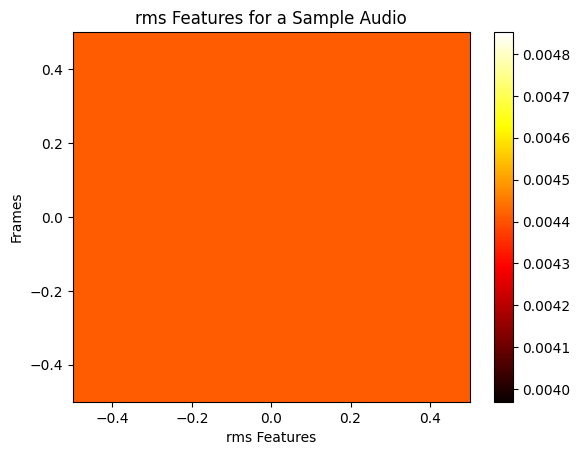

In [8]:
# Select rms features for a sample audio file and convert to float
sample_rms = x[0][42:].astype(float)  # Select the rms features and convert to float

# Reshape the rms features to have a second dimension
sample_rms = sample_rms.reshape(1, -1)

# Plot rms features
plt.imshow(sample_rms, aspect='auto', origin='lower', cmap='hot')
plt.colorbar()
plt.xlabel('rms Features')
plt.ylabel('Frames')
plt.title('rms Features for a Sample Audio')
plt.show()


###**ENSEBMLE MODEL**

In [9]:
# create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(estimator=RandomForestClassifier(), n_features_to_select=37)),
     ('classifier', VotingClassifier( estimators=[
        ('rf', RandomForestClassifier(n_estimators=500, random_state=9)),
        ('svc', SVC(kernel='linear', probability=True, random_state=9)),
        ('knn', KNeighborsClassifier(n_neighbors=6)),
        ('mlp', MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(700,), max_iter=500, learning_rate='adaptive', random_state=9))
    ], voting='soft'))
])


# Fit the model to the training data
pipeline.fit(x, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=37)),
                ('classifier',
                 VotingClassifier(estimators=[('rf',
                                               RandomForestClassifier(n_estimators=500,
                                                                      random_state=9)),
                                              ('svc',
                                               SVC(kernel='linear',
                                                   probability=True,
                                                   random_state=9)),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=6)),
                                              ('mlp',
                                               MLPClassifier(alpha=0.01,
                                                             batch_size=256,
                                                             hidden_layer_sizes=(700,),
                                                             learning_rate='adaptive',
                                                             max_iter=500,
                                                             random_state=9))],
                                  voting='soft'))])

###**Prediction Function for classification**

In [10]:
# Define a function to predict emotion for a given audio file

def predict_emotion(file_path):
  feature = extract_feature(file_path, mfcc=True, pitch=True, rms=True)
  if feature is not None:
    # make prediction using the trained model
    return pipeline.predict(feature.reshape(1, -1))[0]
  else:
    return None

###**Loading of TESS Dataset for classifying and calculating the performance of the ENSEMBLE model**

In [11]:
# Path to the directory containing the audio files
audio_dir = '/content/drive/MyDrive/Dataset_Speech_Emotion_Recognition/test_files6'

# Create an empty list to store the predicted and true labels
predicted_labels = []
true_labels = []

# Get a list of all the WAV files in the directory
test_files = [os.path.join(audio_dir, file) for file in os.listdir(audio_dir) if file.endswith('.wav')]

# Define a dictionary to keep track of the number of correctly predicted emotions
correct_emotions = {'angry': 0, 'fearful': 0, 'surprised': 0, 'sad': 0}

# Iterate through each file and predict the emotion
for file_path in test_files:
    # Get the filename without the extension
    filename = os.path.splitext(os.path.basename(file_path))[0]
    # Extract the emotion label from the filename
    if filename.endswith('angry'):
        label = 'angry'
    elif filename.endswith('fear'):
        label = 'fearful'
    elif filename.endswith('ps'):
        label = 'surprised'
    elif filename.endswith('sad'):
        label = 'sad'
    else:
        label = None
    # Predict the emotion from the audio file
    emotion = predict_emotion(file_path)
    if emotion is not None and label is not None:

      # Append the predicted and true labels to the lists
      predicted_labels.append(emotion)
      true_labels.append(label)
      
      # Increment the count for the predicted emotion if it matches the label
      if emotion == label:
        correct_emotions[emotion] += 1
      print(f'Test file: {filename} -> Predicted Emotion: {emotion}')
    else:
        print(f'Error: Failed to extract features from {file_path}')

# Calculate the accuracy score
num_files = len(test_files)
accuracy = sum(correct_emotions.values()) / num_files * 100
print(f'Accuracy: {accuracy:.2f}%')
print('Number of correct predictions per class:')
for emotion, count in correct_emotions.items():
    print(f'{emotion.capitalize()}: {count}')


Test file: OAF_beg_fear -> Predicted Emotion: fearful
Test file: OAF_back_fear -> Predicted Emotion: fearful
Test file: OAF_chain_fear -> Predicted Emotion: fearful
Test file: OAF_bite_fear -> Predicted Emotion: fearful
Test file: OAF_came_fear -> Predicted Emotion: fearful
Test file: OAF_deep_fear -> Predicted Emotion: fearful
Test file: OAF_get_fear -> Predicted Emotion: fearful
Test file: OAF_gaze_fear -> Predicted Emotion: fearful
Test file: OAF_kite_fear -> Predicted Emotion: fearful
Test file: OAF_hit_fear -> Predicted Emotion: fearful
Test file: OAF_kill_fear -> Predicted Emotion: fearful
Test file: OAF_hire_fear -> Predicted Emotion: surprised
Test file: OAF_jug_fear -> Predicted Emotion: surprised
Test file: OAF_juice_fear -> Predicted Emotion: fearful
Test file: OAF_match_fear -> Predicted Emotion: fearful
Test file: OAF_live_fear -> Predicted Emotion: surprised
Test file: OAF_life_fear -> Predicted Emotion: surprised
Test file: OAF_merge_fear -> Predicted Emotion: surprised


###**Confusion Matrix for above testing**

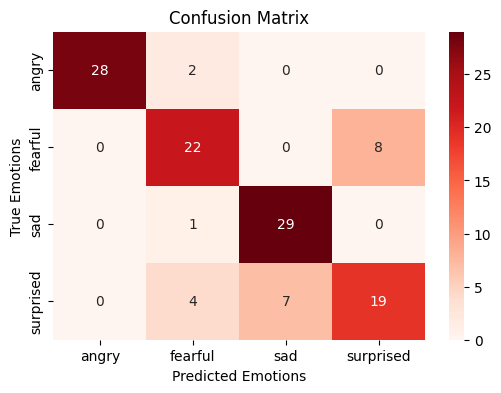

In [12]:
observed_emotions = ['angry', 'fearful', 'sad', 'surprised']

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap='Reds', xticklabels=observed_emotions, yticklabels=observed_emotions)
plt.xlabel('Predicted Emotions')
plt.ylabel('True Emotions')
plt.title('Confusion Matrix')
plt.show()


###**Graph for showing accuracy per emotion**

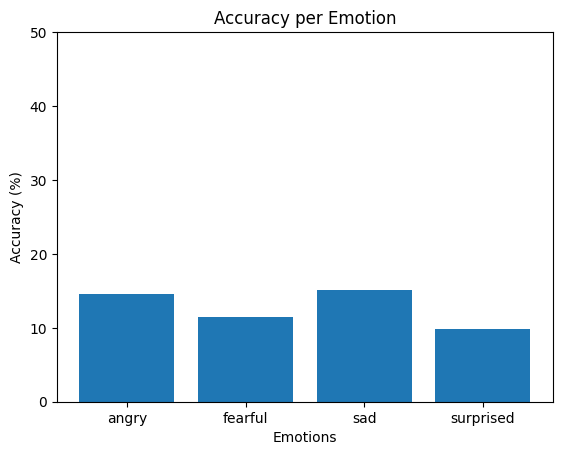

In [15]:
from collections import Counter

# Calculate the count of each emotion in the dataset
emotion_counts = dict(Counter(y))

# Calculate accuracy for each emotion
accuracy_per_emotion = {emotion: correct_emotions[emotion] / emotion_counts[emotion] * 100 for emotion in observed_emotions}

# Plot accuracy per emotion
plt.bar(accuracy_per_emotion.keys(), accuracy_per_emotion.values())
plt.xlabel('Emotions')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Emotion')
plt.ylim([0, 50])
plt.
plt.show()


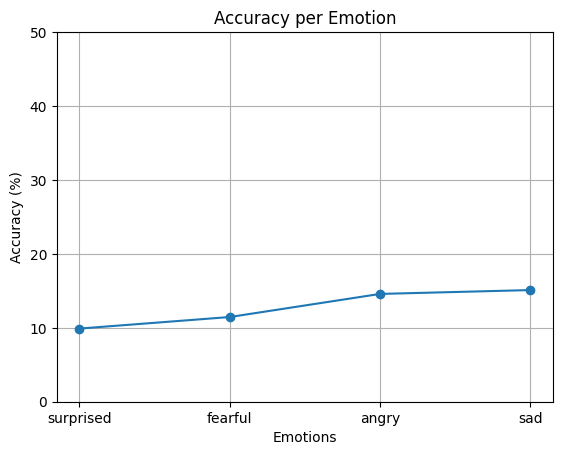

In [24]:
import matplotlib.pyplot as plt
from collections import Counter

# Calculate the count of each emotion in the dataset
emotion_counts = dict(Counter(y))

# Calculate accuracy for each emotion
accuracy_per_emotion = {emotion: correct_emotions[emotion] / emotion_counts[emotion] * 100 for emotion in observed_emotions}

# Sort the emotions in ascending order based on their accuracy
sorted_emotions = sorted(accuracy_per_emotion.keys(), key=lambda x: accuracy_per_emotion[x])

# Plot line graph for accuracy per emotion
plt.plot(sorted_emotions, [accuracy_per_emotion[emotion] for emotion in sorted_emotions], marker='o')
plt.xlabel('Emotions')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Emotion')
plt.ylim([0, 50])
plt.grid(True)
plt.show()

###**Isko Hata na hai sabse puch ke**

In [23]:
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Create a table with the evaluation metrics
table = [
    ['Accuracy', accuracy],
    ['Precision', precision],
    ['Recall', recall],
    ['F1-Score', f1]
]

# Print the table
print(tabulate(table, headers=['Metric', 'Score'], tablefmt='pipe'))


| Metric    |    Score |
|:----------|---------:|
| Accuracy  | 0.816667 |
| Precision | 0.81697  |
| Recall    | 0.816667 |
| F1-Score  | 0.814184 |
